In [1]:
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema


from fink_utils.sso import spins as finkus
import ssptools

In [2]:
# import sys
# sys.path.append('/home/bcarry/Documents/softs/ocapy/gfx/')
# import figure_setup as fs

In [3]:
# To test new ssocards
# rocks.ssodnet.URL_SSODNET = 

# Get ZTF fit

In [4]:
# Local Configuration
bft_file = '/data/ssodnet/ssoBFT-latest.parquet'
data_fink = '/data/fink/tutorials/sso/spins/'
data_fink = './'

# To choose the definition of sets
# gold_silver_choice = 'julien'
gold_silver_choice = 'benoit'

In [5]:
# Threshold for selection (of non-zero values)
thres = 1e-3

# Minimum phase angle to consider
min_phase = 3

In [6]:
# ZTF filters 1: g, 2: r
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])


In [7]:
data = pd.read_parquet(f'{data_fink}data/sso_bft_50_inf_allsolutions.parquet')

In [8]:
data['HG1G2hyb_dSpin'] = np.sqrt( (data['HG1G2hyb_dRA0']*np.cos(np.radians(data['HG1G2hyb_DEC0'])))**2 + data['HG1G2hyb_dDEC0']**2 )


# Remove solutions above 90 deg of latitude
cond = data.HG1G2hyb_DEC0 > 90
data.loc[cond,'HG1G2hyb_DEC0'] = 90
cond = data.HG1G2hyb_DEC0 < -90
data.loc[cond,'HG1G2hyb_DEC0'] = -90

# Spin coordinates: long/lat
# Define angle for astropy
ra = data.HG1G2hyb_RA0*u.degree
dec = data.HG1G2hyb_DEC0*u.degree

# Convert to EC and store in the pandas DataFrame
coords = SkyCoord(ra=ra, dec=dec, distance=200*u.parsec, frame='hcrs')
data['lon'] = coords.heliocentricmeanecliptic.lon.value
data['lat'] = coords.heliocentricmeanecliptic.lat.value



In [9]:
bft = pd.read_parquet(bft_file)

In [10]:
cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ]        

In [11]:
data = data.merge( bft[cols], left_on='name', right_on='sso_name', how='left' )

In [12]:
data

,ssnamenr,number,name,minphase,maxphase,n_days,n_obs,HG_H,HG_dH,HG_G,...,spins.3.DEC0.value,spins.3.long.value,spins.3.lat.value,spins.3.technique,spins.4.obliquity,spins.4.RA0.value,spins.4.DEC0.value,spins.4.long.value,spins.4.lat.value,spins.4.technique
0,3378,3378,Susanvictoria,7.209902,27.973639,694.757685,163,13.835591,0.073765,0.186857,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
1,66214,66214,1999 CO36,2.763971,24.397613,972.951458,73,15.128266,0.062540,0.027824,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
2,30141,30141,Nelvenzon,3.434811,23.955449,621.800359,53,16.165762,0.136274,0.613963,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
3,161891,161891,2007 DW10,1.758005,21.985170,632.723530,61,15.447201,0.046601,0.117947,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
4,85970,85970,Fundacaoterra,0.822790,22.376936,998.833889,54,15.927574,0.101270,0.443576,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104160,64758,64758,2001 XL163,1.497470,29.740566,608.827500,79,15.778768,0.072580,0.114509,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104161,76784,76784,2000 KR71,1.830102,25.589995,990.106308,82,15.468660,0.065853,0.093753,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104162,181960,181960,1999 UM24,1.875814,18.193628,973.847419,107,14.037718,0.076177,0.000482,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104163,366616,366616,2003 NP4,26.050772,37.302272,242.663241,153,16.717611,0.113371,0.149370,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None


In [13]:


# G1G2 mask for HG1G2, HG1G2spin, and hybrid model
maskG1G2 = (data.HG1G2_G1>thres)  & (data.HG1G2_G2>thres) & (1-data.HG1G2_G1-data.HG1G2_G2>thres)
maskG1G2sp = (data.HG1G2sp_G1>thres)  & (data.HG1G2sp_G2>thres) & (1-data.HG1G2sp_G1-data.HG1G2sp_G2>thres)
maskG1G2hyb_g = (data.HG1G2hyb_G1_g>thres)  & (data.HG1G2hyb_G2_g>thres) & (1-data.HG1G2hyb_G1_g-data.HG1G2hyb_G2_g>thres)
maskG1G2hyb_r = (data.HG1G2hyb_G1_r>thres)  & (data.HG1G2hyb_G2_r>thres) & (1-data.HG1G2hyb_G1_r-data.HG1G2hyb_G2_r>thres)
maskG1G2hyb = maskG1G2hyb_g * maskG1G2hyb_r

# G1G2 parameters likely to be wrong due to poor phase coverage
maskPhase = data.minphase<min_phase

# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.HG1G2hyb_RA0>thres) & ( np.abs(360-data.HG1G2hyb_RA0)>thres )  & \
           ( np.abs(data.HG1G2hyb_RA0-180)>thres) & ( np.abs(data.HG1G2hyb_DEC0)>thres ) 

# Mask on Fit status
maskFit = (data['HG1G2hyb_fit']==0) & ( (data['HG1G2hyb_status']==2) | (data['HG1G2hyb_status']==4) )

# General sample for tests
mask = maskG1G2 & maskG1G2sp & maskG1G2hyb & maskPhase & maskSpin

# Sample to be published
maskFINK = maskG1G2hyb & maskSpin & maskFit

print(' All data       :', len(data))
print('  Mask FINK     :', len(data[maskFINK]))
print('  Mask hyb      :', len(data[maskG1G2hyb]))
print('  Mask hyb g    :', len(data[maskG1G2hyb_g]))
print('  Mask hyb r    :', len(data[maskG1G2hyb_r]))
print('  Mask phase    :', len(data[maskPhase]))
print('  Mask Spin     :',len(data[maskSpin]))
print('  Mask          :', len(data[mask]))
print()
print('  Mask G1G2     :', len(data[maskG1G2]))
print('  Mask g1g2spin :', len(data[maskG1G2sp]))


 All data       : 104165
  Mask FINK     : 40582
  Mask hyb      : 47465
  Mask hyb g    : 60711
  Mask hyb r    : 64665
  Mask phase    : 68350
  Mask Spin     : 101714
  Mask          : 29818

  Mask G1G2     : 57063
  Mask g1g2spin : 66319


# Abs mag

In [14]:
data['absolute_magnitude.value']

0         13.61
1         15.08
2         15.50
3         15.20
4         15.53
          ...  
104160    15.60
104161    15.00
104162    13.94
104163    16.60
104164    15.62
Name: absolute_magnitude.value, Length: 104165, dtype: float64

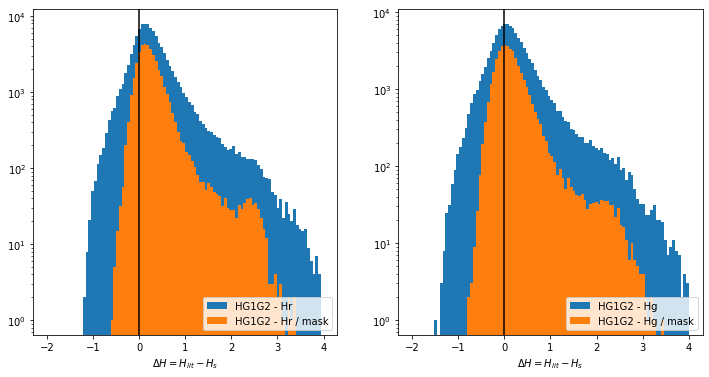

In [15]:
# Different colors
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,4]
b = 100


V_minus_g = -0.32
V_minus_r = 0.13
ax[0].hist( data['absolute_magnitude.value'] - data.HG1G2hyb_H_r - V_minus_r, range=r, bins=b, label='HG1G2 - Hr' )
ax[0].hist( data.loc[maskFINK,'absolute_magnitude.value'] - data.loc[maskFINK,'HG1G2hyb_H_r'] - V_minus_r, range=r, bins=b, label='HG1G2 - Hr / mask' )

ax[1].hist( data['absolute_magnitude.value'] - data.HG1G2hyb_H_g - V_minus_g, range=r, bins=b, label='HG1G2 - Hg' )
ax[1].hist( data.loc[maskFINK,'absolute_magnitude.value'] - data.loc[maskFINK,'HG1G2hyb_H_g'] - V_minus_g, range=r, bins=b, label='HG1G2 - Hg / mask' )

ax[0].axvline(0, color='black')
ax[1].axvline(0, color='black')

for a in ax:
    a.set_xlabel('$\Delta H = H_{lit} - H_s$')
    a.legend(loc='lower right')
    a.set_yscale('log')
    
# fig.savefig(f'{data_fink}/gfx_models/deltaH_spin_hyb_masks.png', facecolor='white')

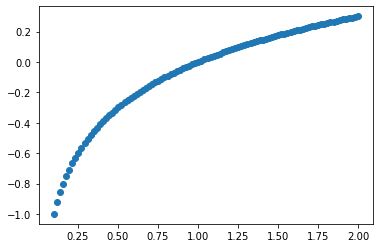

In [17]:
xx = np.linspace(0.1,2,num=100)
plt.scatter( xx, np.log10(xx) )

# Spin distribution

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))


# Histogram of chi2
for err in [5,10,20,30]:
    cond = maskFINK
    cond = cond*(data.HG1G2hyb_dSpin<=err)
    ax[0].hist(data.loc[cond,'HG1G2hyb_chi2red'], bins=50, histtype='step', density=True, range=[0,10],
               label=f'err spin<{err:d}$^o$ ({len(data[cond]):,d})')

    theta = np.linspace(0, np.pi/2, num=90 )
    ax[1].plot( err*np.cos(theta), err*np.sin(theta) )
    
ax[0].axvline(1, ls='--', color='grey')
ax[0].set_xlabel(r'$\chi^2_{red}$')
ax[0].set_ylabel('Density')
ax[0].legend()


# Scatter dRA dDEC
ax[1].scatter( data.HG1G2hyb_dRA0*np.cos(np.radians(data['HG1G2hyb_DEC0'])), data.HG1G2hyb_dDEC0, s=1, alpha=0.05 )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_dRA0']*np.cos(np.radians(data.loc[maskFINK,'HG1G2hyb_DEC0'])), data.loc[maskFINK,'HG1G2hyb_dDEC0'], s=1, alpha=0.05 )
ax[1].set_xlim(0,90)
ax[1].set_ylim(0,90)

ax[1].set_xlabel('Uncertainty on RA$_0$ cos(DEC$_0$) (deg.)')
ax[1].set_ylabel('Uncertainty on DEC$_0$ (deg.)')

# Cumulative dSpin
r = [0,90]
b = 90
ax[2].hist( data.HG1G2hyb_dSpin, cumulative=True, density=False, range=r, bins=b, label='All' )
ax[2].hist( data.loc[maskFINK,'HG1G2hyb_dSpin'], cumulative=True, density=False, range=r, bins=b, label='Select' )

ax[2].grid()
ax[2].set_xlabel('Uncertainty on spin coordinates (deg.)')
ax[2].legend(loc='upper left')

# fig.savefig(f'{data_fink}plots/uncertainties_spin.png', facecolor='white', dpi=150)


In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

cond = data.ssnamenr==data.ssnamenr
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15)

cond = maskSpin
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15)

coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
# fig.savefig(f'{data_fink}plots/ra0_vs_dec0_with_flip.png', facecolor='white', dpi=150)



- There are a few weird solution at RA0=0 or RA0=360 
- We need to flip RA/DEC of half the solution

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].hist( data.HG1G2hyb_RA0, range=[0,360], bins=361, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'HG1G2hyb_RA0'], range=[0,360], bins=361, density=True, label='Select' )
ax[0].legend()
ax[0].set_xlabel('RA_0')

ax[1].hist( data.HG1G2hyb_DEC0, range=[-90,90], bins=181, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'HG1G2hyb_DEC0'], range=[-90,90], bins=181, density=True, label='Select' )
ax[1].legend()
ax[1].set_xlabel('DEC_0')

In [ ]:
# Flip half of the solution
cond = (data.index %2 ==0 )
xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

data.loc[cond,xax] = (data.loc[cond,xax]+180) % 360
data.loc[cond,yax] = -data.loc[cond,yax]

# Convert (again) to EC
coords = SkyCoord(ra=data.loc[cond,xax]*u.deg, dec=data.loc[cond,yax]*u.deg, distance=200*u.parsec, frame='hcrs')
data.loc[cond,'lon'] = coords.heliocentricmeanecliptic.lon.value
data.loc[cond,'lat'] = coords.heliocentricmeanecliptic.lat.value

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

cond = data.ssnamenr==data.ssnamenr
xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

ax.scatter( data.loc[cond,xax], 
            data.loc[cond,yax], 
            s=2, alpha=0.15)

ax.scatter( data.loc[maskFINK,xax], 
            data.loc[maskFINK,yax], 
            s=2, alpha=0.15)

coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
# fig.savefig(f'{data_fink}plots/ra0_vs_dec0_with_flip.png', facecolor='white', dpi=150)



# Compare with literature

In [ ]:
data['spins.1.technique'].value_counts()

In [ ]:
# Compute angular distances
spin_version = np.array(['A','B'])

for ks in ['1','2','3','4']:
    data[f'spins.{ks}.distance'] = np.nan
    cond = (~data[f'spins.{ks}.RA0.value'].isna())
    
    #------------------------------------------------------------------------------------------
    # A: Original spins
    data.loc[cond,f'spins.{ks}.distance.A'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'HG1G2hyb_RA0','HG1G2hyb_DEC0']].apply(
        lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.A'] = (data.loc[cond,f'spins.{ks}.RA0.value']-data.loc[cond,'HG1G2hyb_RA0'] ) * np.cos(np.radians(data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.A'] = (data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'HG1G2hyb_DEC0'] )

    #------------------------------------------------------------------------------------------
    # B: RA-180 & Flip DEC
    data.loc[cond,f'spins.{ks}.distance.B'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'HG1G2hyb_RA0','HG1G2hyb_DEC0']].apply(
        lambda x: np.degrees(angular_separation( np.radians( (x[0]+180) % 360 ), np.radians(-x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.B'] = ( ((data.loc[cond,f'spins.{ks}.RA0.value']+180.0) % 360 )-data.loc[cond,'HG1G2hyb_RA0'] ) * np.cos(np.radians(-data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.B'] = (-data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'HG1G2hyb_DEC0'] )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.closest'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: int(np.argmin(x)), axis=1 )
    data = data.astype({f'spins.{ks}.closest':'Int64'})

    data.loc[cond,f'spins.{ks}.distance'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                            f'spins.{ks}.distance.B']].apply( lambda x: np.min(x), axis=1 )
    data.loc[cond,f'spins.{ks}.version'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: spin_version[np.argmin(x)], axis=1 )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.delta_RA'] = data.loc[cond, [f'spins.{ks}.delta_RA.A',
                                                            f'spins.{ks}.delta_RA.B', 
                                                            f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )
    data.loc[cond,f'spins.{ks}.delta_DEC'] = data.loc[cond, [f'spins.{ks}.delta_DEC.A',
                                                             f'spins.{ks}.delta_DEC.B', 
                                                             f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )

    
# Select the closest angularly
cond = ~data[f'spins.1.distance'].isna()
data.loc[cond,'spins.closest'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: int(np.argmin(x)), axis=1 )
data = data.astype({'spins.closest':'Int64'})

data.loc[cond,'spins.distance'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: np.min(x), axis=1 )
data.loc[cond,'spins.delta_RA'] = data.loc[cond, [f'spins.1.delta_RA',
                                                  f'spins.2.delta_RA',
                                                  f'spins.3.delta_RA',
                                                  f'spins.4.delta_RA', 
                                                  f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )
data.loc[cond,'spins.delta_DEC'] = data.loc[cond, [f'spins.1.delta_DEC',
                                                   f'spins.2.delta_DEC',
                                                   f'spins.3.delta_DEC',
                                                   f'spins.4.delta_DEC', 
                                                   f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )



In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

r = [0,90]
b = 50
ax[0].hist( data.loc[cond,'spins.distance'], range=r, bins=b, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, label='Select' )
ax[0].legend()
ax[0].set_xlabel('Distances / deg')
ax0 = ax[0].twinx()
ax0.hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax[0].set_xlim(r)

ax[1].hist( data.loc[cond,'spins.delta_RA'], range=r, bins=b, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, label='Select' )
ax[1].legend()
ax[1].set_xlabel('$\Delta$ RA cos(DEC)')
ax1 = ax[1].twinx()
ax1.hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax[1].set_xlim(r)

ax[2].hist( data.loc[cond,'spins.delta_DEC'], range=r, bins=b, density=True, label='All' )
ax[2].hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, label='Select' )
ax[2].legend()
ax[2].set_xlabel('$\Delta$ DEC')
ax2 = ax[2].twinx()
ax2.hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax[2].set_xlim(r)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

ax[0].scatter( data.loc[cond,'minphase'], data.loc[cond,'spins.distance'], label='All' )
ax[0].scatter( data.loc[maskFINK,'minphase'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[0].legend()
ax[0].set_xlabel('Min phase')
ax[0].set_ylabel('Distances / deg')
ax[0].set_xlim(0,10)


ax[1].scatter( data.loc[cond,'HG1G2hyb_rms'], data.loc[cond,'spins.distance'], label='All' )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_rms'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[1].legend()
ax[1].set_xlabel('RMS')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

r = [0,5]
b = 51
ax[2].hist( data.loc[cond,'spins.distance']/data.loc[cond,'HG1G2hyb_dSpin'], range=r, bins=b, label='All' )
ax[2].hist( data.loc[maskFINK,'spins.distance']/data.loc[maskFINK,'HG1G2hyb_dSpin'], range=r, bins=b, label='Select' )
ax2 = ax[2].twinx()
ax2.hist( data.loc[cond,'spins.distance']/data.loc[cond,'HG1G2hyb_dSpin'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax2.hist( data.loc[maskFINK,'spins.distance']/data.loc[maskFINK,'HG1G2hyb_dSpin'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[2].set_xlim(r)

ax[2].legend()
ax[2].set_xlabel('abs mag')
ax[2].set_yscale('log')
ax[2].set_ylabel('Distances / deg')


In [ ]:
data.columns[:80]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

ax[0].scatter( data.loc[cond,'n_days'], data.loc[cond,'spins.distance'], label='All' )
ax[0].scatter( data.loc[maskFINK,'n_days'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[0].legend()
ax[0].set_xlabel('N days')
ax[0].set_ylabel('Distances / deg')

ax[1].scatter( data.loc[cond,'HG1G2hyb_chi2red'], data.loc[cond,'spins.distance'], label='All' )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_chi2red'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[1].legend()
ax[1].set_xlabel('chi2 red')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

ax[2].scatter( data.loc[cond,'absolute_magnitude.value'], data.loc[cond,'spins.distance'], label='All' )
ax[2].scatter( data.loc[maskFINK,'absolute_magnitude.value'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[2].legend()
ax[2].set_xlabel('abs mag')
# ax[2].set_xscale('log')
ax[2].set_ylabel('Distances / deg')


In [ ]:
r = [0,20]
b = 200 
plt.hist(data['HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

- fishy: the object with spins have shitty chi2red!
- Explanation: there is bias for high amplitude for LC-derived spins -> bad for HG1G2hybrid (LC not taken into account)

In [ ]:
r = [0,0.5]
b = 100 
# plt.hist(data['HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

In [ ]:
fig, ax = plt.subplots()

ax.hist( data.loc[cond,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='lit')
ax.hist( data.loc[maskFINK,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='fink' )

ax.set_xscale('log')
ax.legend()

In [ ]:
cond = maskFINK
lim_spin = 30
spin_v = '1'
cond = cond * (data[f'spins.{spin_v}.distance'] < lim_spin)
data.loc[cond,f'spins.{spin_v}.technique'].value_counts()

# plt.hist( data.loc[cond,'spins.1.distance'] )

In [ ]:
cond = maskFINK
cond = cond * (data[f'spins.{spin_v}.distance'] < lim_spin)
cond = cond * (data[f'spins.{spin_v}.technique']=='Radar')

cols = ['number','name', #'minphase','maxphase','n_days',
        'HG1G2hyb_RA0','HG1G2hyb_DEC0',
        'spins.1.RA0.value','spins.1.DEC0.value', 'spins.1.version',
        'spins.2.RA0.value','spins.2.DEC0.value', 'spins.2.version',
        'spins.1.distance', 'spins.2.distance']
data.loc[cond,cols].sort_values(by='number')
# data.loc[cond,'spins.1.technique'].value_counts()

In [ ]:
cond = maskFINK
data[cond].sort_values(by='sso_number').head(20)

In [ ]:
cond = maskFINK
cols = ['number','name', #'minphase','maxphase','n_days',
        'HG1G2hyb_RA0','HG1G2hyb_DEC0',
        'spins.1.RA0.value','spins.1.DEC0.value', 'spins.1.version',
        'spins.2.RA0.value','spins.2.DEC0.value', 'spins.2.version',
        'spins.1.distance', 'spins.2.distance']
data.loc[cond,cols].sort_values(by='number').head(20)

In [ ]:
data.columns[:80]

# Obliquity

In [ ]:
# Obliquity of the spin
data['lon_orbit'] = data['orbital_elements.node_longitude.value'] - 90
data['lat_orbit'] = 90. - data['orbital_elements.inclination.value']
data['obliquity'] = data[['lon','lat', 'lon_orbit','lat_orbit']].apply(
    lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
)


In [ ]:
fig, ax = plt.subplots(figsize=fs.figsize(0.5), 
                      gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

cond = data.ssnamenr==data.ssnamenr
cond = maskFINK
ax.scatter( data.loc[cond,'diameter.value'],
            data.loc[cond,'obliquity'], 
            marker='.',
            color=colors[0], 
            s=2, 
            alpha=0.15 )

ax.set_xscale('log')
ax.set_xlim(1,300)
ax.set_ylim(0,180)
ax.set_xlabel('Diameter / km')
ax.set_ylabel('Obliquity / deg')


ax.set_xticks([1,10,100])
ax.set_xticklabels(['1','10','100'])
ax.set_yticks([0,30,60,90,120,150,180])

fig.savefig(f'{data_fink}plots/obliquity_vs_diameter.png', facecolor='white', dpi=150)


In [ ]:
cond = maskFINK & (data['diameter.value']<10)
fig, ax = plt.subplots()

r = [0,180]
b = 37
ax.hist( data.loc[cond,'obliquity'], bins=b, range=r )

# Oblateness

In [ ]:
damit = pd.read_csv( f'{data_fink}/data/damit.csv' )

In [ ]:
np.mean(damit.R), np.mean(damit.R2)

In [ ]:
fig, ax = plt.subplots(figsize=fs.figsize(0.5), 
                      gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

r = [0,1]
b = 50

colors = ['#15284F', '#F5622E']


ax.hist( damit.R, range=r, bins=b, 
        color='lightgray', 
        density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )

ax.hist( damit.R2, range=r, bins=b, 
        color='slategray', 
        density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )
# ax.hist( data.loc[maskFINK,'HG1G2hyb_R'], range=r, bins=b, density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

cond = (data.HG1G2hyb_dR<0.9) & maskFINK
ax.hist( data.loc[cond,'HG1G2hyb_R'], range=r, bins=b, 
         color=colors[0], 
        density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

ax.set_ylim(0,4)
ax.set_xlabel('Oblateness R')
ax.set_ylabel('Count density')
ax.legend(loc='upper left')

fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)


In [ ]:
# damit.sort_values(by='R').head(40)
cond = maskFINK & (data.HG1G2hyb_R>0.18)
data[cond].sort_values(by='HG1G2hyb_R').head(40)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

r = [0,1]
b = 50


cond = maskFINK

ax[0].scatter( data.loc[cond,'HG1G2hyb_G1_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )
ax[1].scatter( data.loc[cond,'HG1G2hyb_G2_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )
ax[2].scatter( data.loc[cond,'HG1G2hyb_G1_r']+data.loc[cond,'HG1G2hyb_G2_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )

ax[0].set_xlabel('G1')
ax[1].set_xlabel('G2')
ax[2].set_xlabel('G1 + G2')
ax[0].set_ylabel('R')

# ax.legend(loc='upper left')

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))

r = [0,1]
b = 50

cond = data['HG1G2hyb_R']<0.2

ax.scatter( data.loc[cond,'HG1G2hyb_G1_r'], data.loc[cond,'HG1G2hyb_G2_r'], marker='.', alpha=0.15 )

# ax[0].set_xlabel('G1')
# ax[1].set_xlabel('G2')
# ax[2].set_xlabel('G1 + G2')
# ax[0].set_ylabel('R')

# ax.legend(loc='upper left')